In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
import japanize_matplotlib
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#試合データの読み込み
atp2018=pd.read_csv("../tennis_atp/atp_matches_2018.csv")

In [3]:
#疲労度の取得
#alpha:疲労残存率
#適用可能なのはR128の大会のみ

def get_fatigue(alpha):
    out=atp2018[(atp2018["best_of"]==5)]
    out["winner_totalminutes"]=-99
    out["loser_totalminutes"]=-99
    for index, row in out.iterrows():
        if row["round"]=="R128":
            out.loc[index,"winner_totalminutes"]=0
            out.loc[index,"loser_totalminutes"]=0
        elif row["round"]=="R64":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R128")]["minutes"].values
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R128")]["minutes"].values
        elif row["round"]=="R32":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R64")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R64")]["winner_totalminutes"].values  * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R64")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"]) 
                                                     & (out["round"]=="R64")]["winner_totalminutes"].values * alpha
        elif row["round"]=="R16":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["winner_totalminutes"].values * alpha
        elif row["round"]=="QF":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["winner_totalminutes"].values * alpha
        elif row["round"]=="SF":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["winner_totalminutes"].values * alpha
        elif row["round"]=="F":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["winner_totalminutes"].values * alpha
    
    #レーティングの付与
    out["winner_rating"]=out["winner_name"].map(d)
    out["loser_rating"]=out["loser_name"].map(d)

    out["rate_diff"]=out["winner_rating"]-out["loser_rating"]
    out["fatigue_diff"]=out["winner_totalminutes"]-out["loser_totalminutes"]

    return out

In [4]:
#イロレーティングの読み込み
elo2018=pd.read_csv("../elo/Rankings_2018_ye.csv")

In [5]:
elo2018.head()

,rank,name,country_name,country_id,points,bestRank,bestRankDate,rankDiff,pointsDiff,bestPoints
0,1,Rafael Nadal,Spain,ESP,2408,1,2008-06-16,0,0,2552
1,2,Novak Djokovic,Serbia,SRB,2401,1,2011-03-21,0,0,2629
2,3,Roger Federer,Switzerland,SUI,2356,1,2003-08-11,0,0,2550
3,4,Juan Martin Del Potro,Argentina,ARG,2264,3,2010-06-07,0,0,2329
4,5,Andy Murray,United Kingdom,GBR,2255,2,2009-04-19,0,0,2500


In [6]:
#表記揺れへの対応
elo2018.loc[elo2018['name'] == "Frances Tiafoe", 'name'] = "Francis Tiafoe"
elo2018.loc[elo2018['name'] == "Stan Wawrinka", 'name'] = "Stanislas Wawrinka"

In [7]:
#名前とレーティングの辞書化
d={}
for i,j in zip(elo2018["name"].values,elo2018["points"].values):
    d[i]=j

In [8]:
#疲労度の取得
data=get_fatigue(0.8)

#4大大会でないデータを除外
data=data[data["round"]!="RR"]

#レーティングのデータが入っていない人がいる行を除外
data=data.dropna(subset=["winner_rating","loser_rating"])

#回帰に入れるためのデータ整形
X1=data[["rate_diff","fatigue_diff"]]
X1["win"]=1

#勝敗を反転させたデータの追加
X2=data[["rate_diff","fatigue_diff"]]
X2["rate_diff"]=-X2["rate_diff"]
X2["fatigue_diff"]=-X2["fatigue_diff"]
X2["win"]=0

X12=pd.concat([X1,X2])
y=X12["win"]
X=X12.drop(["win"],axis=1)

In [9]:
#ロジスティック回帰の実施
import statsmodels.api as sm
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit(disp=0)

In [10]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    win   No. Observations:                  964
Model:                          Logit   Df Residuals:                      962
Method:                           MLE   Df Model:                            1
Date:                Sun, 10 Nov 2019   Pseudo R-squ.:                  0.2928
Time:                        11:20:59   Log-Likelihood:                -472.57
converged:                       True   LL-Null:                       -668.19
Covariance Type:            nonrobust   LLR p-value:                 4.417e-87
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
rate_diff        0.0070      0.000     14.147      0.000       0.006       0.008
fatigue_diff    -0.0054      0.002     -3.239      0.001      -0.009      -0.002
================================================================================
"""

In [11]:
#オッズ比
params = logit_res.params
conf = logit_res.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
pd.DataFrame(np.exp(conf))

,2.5%,97.5%,OR
rate_diff,1.006018,1.007961,1.006989
fatigue_diff,0.991332,0.997861,0.994591


In [12]:
#錦織とナダルのサンプルデータ表示用

x=[]
winrate=[]
for i in range(-30,30):
    x.append(i*10)
    winrate.append(logit_res.predict(np.array([[(2185-2408),i*10]])))

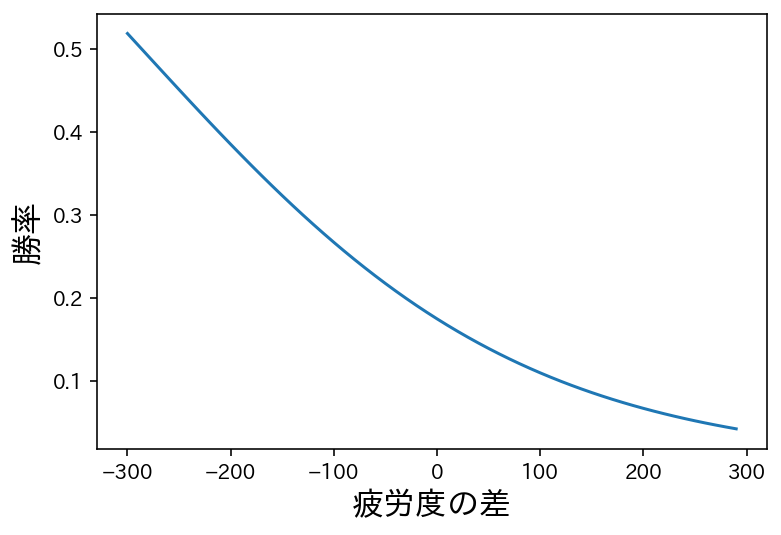

In [13]:
plt.plot(x,winrate)
plt.xlabel("疲労度の差",fontsize=16)
plt.ylabel("勝率",fontsize=16)
plt.show()